In [1]:
import matplotlib.pyplot as plt

In [1]:
import os
import numpy as np
import warnings
import torch
import pytorch_lightning as pl
from pl_bolts.datamodules import MNISTDataModule, FashionMNISTDataModule, CIFAR10DataModule, ImagenetDataModule
from datamodules import SmallNORBDataModule, CIFAR100DataModule
from pytorch_lightning.loggers import WandbLogger

#from models import Agglomerator
from utils import TwoCropTransform, count_parameters
from custom_transforms import Transforms

from absl import flags
from einops import rearrange, repeat

import matplotlib.pyplot as plt
from torch import nn, Tensor
import math

In [17]:
asdf = True

In [2]:
x = torch.Tensor([[1,2,3],[4,5,6],[7,8,9]])
y = torch.Tensor([[1,1,1]])

In [21]:
print(f'Hahaha {asdf:b}')

Hahaha 1


In [12]:
torch.cat([x,repeat(y,'b n -> (k b) n', k=3)], dim=1)

tensor([[1., 2., 3., 1., 1., 1.],
        [4., 5., 6., 1., 1., 1.],
        [7., 8., 9., 1., 1., 1.]])

In [2]:
from positional_encodings.torch_encodings import PositionalEncoding2D

In [3]:
from torchvision.transforms import Lambda, Compose, CenterCrop, RandAugment, AutoAugment, AutoAugmentPolicy, RandomCrop, RandomInvert, RandomPosterize, RandomSolarize, RandomResizedCrop, RandomAffine, GaussianBlur, RandomHorizontalFlip, Resize, RandomApply, ColorJitter, RandomGrayscale, RandomPerspective, RandomRotation, ToTensor, Normalize, RandomErasing, CenterCrop

In [3]:
penc = PositionalEncoding2D(10)

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [30]:
pe = PositionalEncoding(d_model=10, dropout=0.0)

In [16]:
asdf = repeat(torch.arange(8), 'd -> b l1 l2 d', l1=5, l2=5, b=1)

In [18]:
penc(asdf)

tensor([[[[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
            1.0000],
          [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.8415,
            0.5403],
          [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.9093,
           -0.4161],
          [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.1411,
           -0.9900],
          [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000, -0.7568,
           -0.6536]],

         [[ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000,  0.0000,
            1.0000],
          [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000,  0.8415,
            0.5403],
          [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000,  0.9093,
           -0.4161],
          [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000,  0.1411,
           -0.9900],
          [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000, -0.7568,
           -0.6536]],

         [[ 0.9093, -0.4161,  0.0927,  0.9957,

In [4]:
class GaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [5]:
class DenoisingTransform:
    """Creates a pair of clear-corrupted image"""
    def __init__(self, base_transform, corrupt_transform):
        self.base = base_transform
        self.corrupt = corrupt_transform

    def __call__(self, x):
        x = self.base(x)
        return [x, self.corrupt(x)]

In [18]:
base=Compose([RandAugment(), ToTensor(),Normalize((0.5,), (0.5,))])
corrupt=Compose([GaussianNoise(mean=0.,std=0.1), RandomPatchErasing(patch_size=4, p=0.3)])
transform = DenoisingTransform(base, corrupt)

In [19]:
dm = MNISTDataModule('./datasets', batch_size=100, shuffle=True, pin_memory=True, drop_last=True)
dm.train_transforms = transform
dm.setup()
l = dm.train_dataloader()
img = next(iter(l))

/home/leko/.local/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:95: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/leko/.local/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:88: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/leko/.local/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:107: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/leko/.local/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:126: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


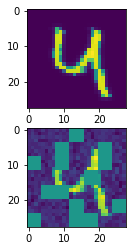

In [22]:
img = next(iter(l))
fig, arr = plt.subplots(2,1)

arr[0].imshow(img[0][0][81].squeeze())
arr[1].imshow(img[0][1][81].squeeze())

In [3]:
x = torch.Tensor([1,2,3,4])

In [4]:
torch.cat([x,x])

tensor([1., 2., 3., 4., 1., 2., 3., 4.])

In [87]:
a=torch.stack([torch.arange(8), torch.arange(8)])

In [107]:
a=torch.Tensor([[1,0],[0,1]])
b=torch.ones((3,2,2))

In [124]:
c=torch.kron(a,b).bool()
c

tensor([[[ True,  True, False, False],
         [ True,  True, False, False],
         [False, False,  True,  True],
         [False, False,  True,  True]],

        [[ True,  True, False, False],
         [ True,  True, False, False],
         [False, False,  True,  True],
         [False, False,  True,  True]],

        [[ True,  True, False, False],
         [ True,  True, False, False],
         [False, False,  True,  True],
         [False, False,  True,  True]]])

In [113]:
xd = torch.full((3,4,4),5)

In [126]:
xd[c]=0

In [127]:
xd

tensor([[[0, 0, 5, 5],
         [0, 0, 5, 5],
         [5, 5, 0, 0],
         [5, 5, 0, 0]],

        [[0, 0, 5, 5],
         [0, 0, 5, 5],
         [5, 5, 0, 0],
         [5, 5, 0, 0]],

        [[0, 0, 5, 5],
         [0, 0, 5, 5],
         [5, 5, 0, 0],
         [5, 5, 0, 0]]])

In [7]:
class RandomPatchErasing(torch.nn.Module):

    def __init__(self, patch_size, p=0.5, value=0, inplace=False):
        super().__init__()
        self.patch_size = patch_size
        self.p = p
        self.value = value
        self.inplace = inplace

    def forward(self, img):
        """
        Args:
            img (Tensor): Tensor image to be erased.

        Returns:
            img (Tensor): Erased Tensor image.
        """
        c, h, w = img.shape
        num_patch_side = h // self.patch_size
        num_patch = num_patch_side ** 2
        num_masked = int(self.p * num_patch)

        # Compute which patch to mask
        masked = torch.cat([torch.ones(num_masked), torch.zeros(num_patch-num_masked)])[torch.randperm(num_patch)]
        masked = masked.view((num_patch_side,num_patch_side))
        patch_mask = torch.ones((c, self.patch_size, self.patch_size))

        # Kronecker product to produce mask
        mask = torch.kron(masked, patch_mask).bool()

        # Apply mask
        img[mask] = self.value

        return img

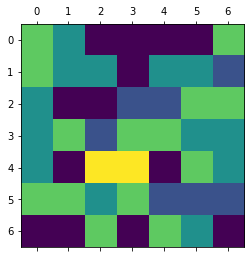

In [28]:
plt.matshow(kmeans.labels_.reshape((7,7)))

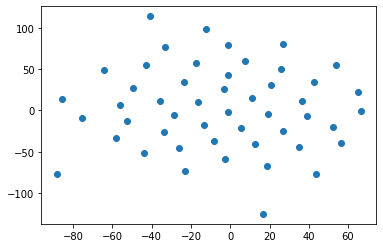

In [26]:
plt.scatter(tsne_results[:,0],tsne_results[:,1])

In [23]:
from scipy.spatial import distance_matrix

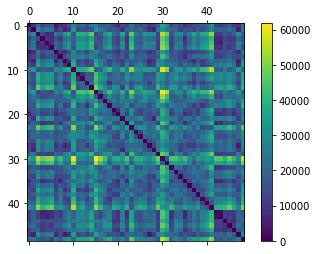

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(distance_matrix(a,a), interpolation='nearest')
fig.colorbar(cax)

In [25]:
distance_matrix(a,a)

array([[    0.        ,  9754.51596038, 22340.84427739, ...,
        10848.63006656, 10019.91302593, 22918.29498314],
       [ 9754.51596038,     0.        , 30470.75479518, ...,
        17569.18983199,  5697.39436438, 26266.72014298],
       [22340.84427739, 30470.75479518,     0.        , ...,
        18435.94185885, 31633.27436665, 18316.28895424],
       ...,
       [10848.63006656, 17569.18983199, 18435.94185885, ...,
            0.        , 16489.61972568, 20963.56472503],
       [10019.91302593,  5697.39436438, 31633.27436665, ...,
        16489.61972568,     0.        , 28598.96377594],
       [22918.29498314, 26266.72014298, 18316.28895424, ...,
        20963.56472503, 28598.96377594,     0.        ]])

In [33]:
s = 0
for i in range(len(d)):
    for j in range(i):
        s += d[i,j]
        
s = s/(len(d)**2-len(d))

In [34]:
s

11479.623587946966